In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 타이타닉 생존자 예측기

연습: 타이타닉 데이터셋 다루기.  https://homl.info/titanic.tgz에서 데이터를 받아 2챕터에서 한 것처럼 압축해제 하면 된다.  _train.csv와 test.csv 두개의 CSV파일을 받을 수 있다. 목표는 다른 열을 기반으로 생존 열을 예측할 수 있는 분류기를 훈련하는 것이다.

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [ ]:
train_data, test_data = load_titanic_data()

데이터는 이미 텍스트셋과 훈련셋으로 나뉘어져 있지만, 테스트 데이터에는 레이블이 
포함되어 있지 않다. 훈련 데이터를 이용해 최선의 모델을 만들어 테스트 데이터에 예측하여 케글에 올려 점수를 확인하는 것이다.

훈련셋의 맨 위 몇행을 확인해보자.

In [ ]:
train_data.head()

각 속성의 의미는 다음과 같다.

* **PassengerId**: 각 승객의 고유번호
* ***Survived**: 타깃: 0는 사망, 1은 생존을 의미
* **Pclass**: 승객의 클래스
* **Name, Sex, Age**: 개인정보
* **SibSp**: 승객의 형제, 배우자 수
* **Parch**: 승객의 자식 및 부모 수
* **Ticket**: 티켓 ID
* **Fare**: 비용(파운드)
* **Cabin**: 승객의 객실 번호
* **Embarked**: 승객의 승선 장소목표는 이러한 속성들을 이용해 승객이 살아남았는지 아닌지를 예측하는 것이다.

PassengerId 열을 인덱스 열로 명시적으로 설정해 보자.

목표는 이러한 속성들을 이용해 승객이 살아남았는지 아닌지를 예측하는 것이다.

In [ ]:
# test_data의 PassengerID속성을 사용하기 위해 미리 복사해두기.
test_data_=test_data.copy()
# Survived속성이 없는 것이 확인 가능하다.
test_data_.info()

PassengerId 열을 인덱스 열로 명시적으로 설정해 보자.

In [ ]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [ ]:
# 누락데이터 확인
train_data.info()

In [ ]:
train_data[train_data["Sex"]=="female"]["Age"].median()

Age, Cabin, Embarked가 누락이 있다(특히, Cabin은 77%가 null이다). 그러므로 Cabin은 무시하고 나머지에 집중하자. Age속성은 19%의 null값을 가지므로 이 null을 어떻게 처리할지 정해야 한다.

null값을 중앙값으로 바꾸는것이 합리적으로 보인다. 다른 속성을 기반으로 나이를 예측하면 좀 더 똑똑해 질 것이다.(예를 들어, 연령의 중앙값은 1급에서 37세, 2급에서 29세, 3급에서 24세이다). 

이름 및 티켓 속성은 가치가 있을 수 있지만 모델이 사용할 수 있는 유용한 숫자로 변환하기가 약간 까다로울 것 같으므로, 앞으로 무시한다.하지만 우리는 단순하게 하기 위해 전체 연령의 중앙값을 사용할 것이다.

이름 및 티켓 속성은 가치가 있을 수 있지만 모델이 사용할 수 있는 유용한 숫자로 변환하기가 약간 까다로울 것 같으므로, 앞으로 무시한다.

In [ ]:
train_data.describe()

생존률이 40%에 가깝기 때문에 정확도는 모델 평가의 합리적인 척도가 될 것이다.

In [ ]:
# 훈련셋의 타겟 정보 확인
train_data["Survived"].value_counts()

범주형 속성을 간단히 살펴보자.

In [ ]:
train_data["Pclass"].value_counts()

In [ ]:
train_data["Sex"].value_counts()

In [ ]:
# C=Cherbourg, Q=Queenstown, S=Southampton.
train_data["Embarked"].value_counts()

In [ ]:
# 숫자형 속성을 처리하는 전처리 파이프라인
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

In [ ]:
# 범주형 속성을 처리하는 전처리 파이프라인
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

cat_pipeline = Pipeline([
        ("ordinal_encoder", OrdinalEncoder()),    
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [ ]:
# 두 속성 파이프라인 합치기
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

이제 원시 데이터를 가져와 원하는 기계 학습 모델에 제공할 수 있는 수치 입력 기능을 출력하는 전처리 파이프라인이 생성되었다.

In [ ]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

In [ ]:
y_train = train_data["Survived"]

이제 분류기를 훈련시킬 준비가 되었다. RandomForestClassifier부터 시작해보자.

In [ ]:
from sklearn.ensemble import RandomForestClassifier


forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

In [ ]:
# 테스트셋 예측에 활용
X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)

이제 CSV파일을 만들어 케글에 업로드해보자(케글에서 형식 존중). 그전에 교차검증을 통해 모델이 얼마나 좋은지 확인해 보자.

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

In [ ]:
# 예측한 결과를 바탕으로 CSV파이 생성하기
# test_data의 PassengerID와 예측결과인 y_pred를 케글에서 필요한 형식으로 변환
predict = pd.DataFrame({
    "PassengerID":test_data_["PassengerId"],
    "Survived":y_pred
})

predict.to_csv('submission.csv', index=False)

In [ ]:
#케글에 업로드 할 때 418개의 값이 필요함을 확인.
predict.info()

**업로드 결과**

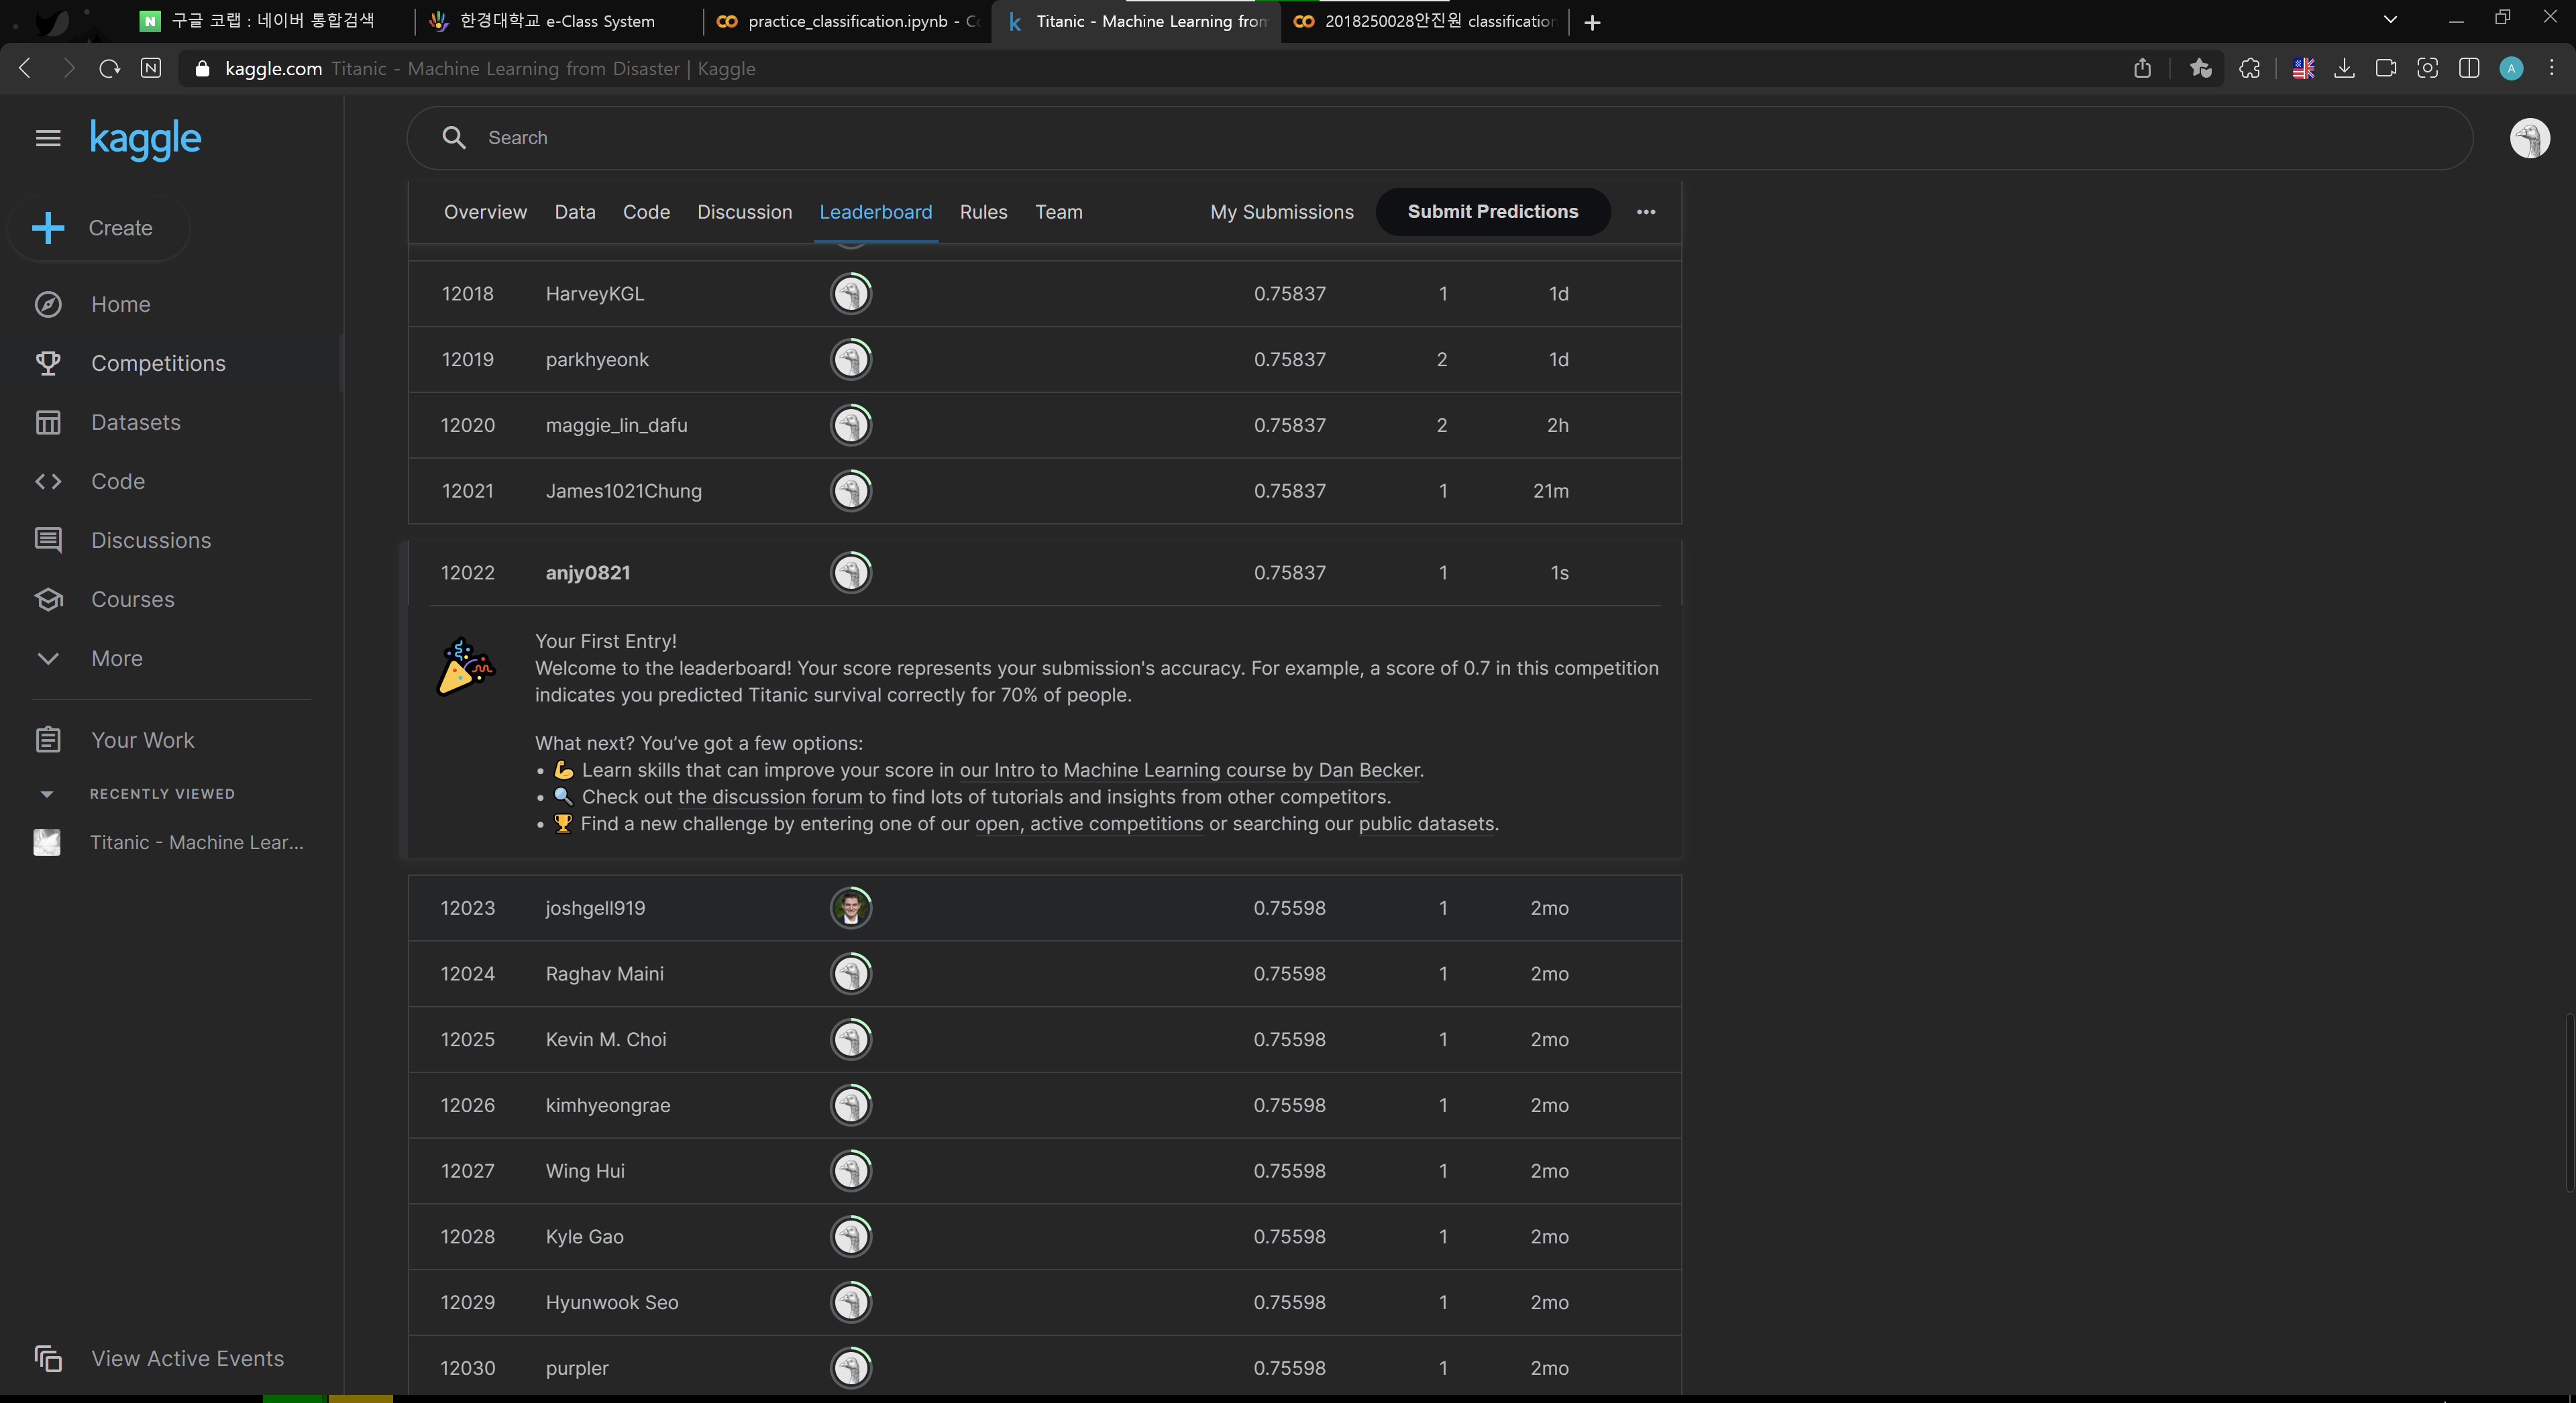